In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, save_model, load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
import os

In [2]:
syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))

-0.0166258178256 0.0347767817719 0.0025805871334024376


In [3]:
count = 0
for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
            print(i,j)
            print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]
print(count)

0 10
9.33387814202e-05 9.33387814201e-05
0 75
9.05443602016e-05 9.05443602015e-05
2 68
5.84269431267e-05 5.84269431266e-05
3 107
0.000136763299594 0.000136763299593
3 175
6.821596824e-05 6.82159682399e-05
4 19
0.000218987354692 0.000218987354691
7 224
6.57226796625e-05 6.57226796624e-05
8 13
9.57880153294e-05 9.57880153295e-05
8 26
0.00661609551033 0.00661609551034
8 96
0.000253469634018 0.000253469634019
8 154
9.9063520192e-05 9.90635201921e-05
8 227
-3.79691626194e-06 -3.79691626193e-06
8 231
0.000255139378748 0.000255139378749
9 157
6.23071374699e-05 6.23071374698e-05
10 116
5.51821214604e-05 5.51821214603e-05
12 198
6.16747798165e-05 6.16747798164e-05
13 18
7.67427279413e-05 7.67427279412e-05
13 121
9.04513387774e-05 9.04513387773e-05
13 218
6.97373549281e-05 6.9737354928e-05
14 68
3.2722108844e-06 3.27221088441e-06
14 81
9.91102935493e-06 9.91102935494e-06
14 85
-1.71950071068e-07 -1.71950071066e-07
15 92
0.000216399317748 0.000216399317747
17 172
1.76995240946e-07 1.76995240947e-

In [4]:
file = 'data/jla_lcparams.txt'

data = pd.read_csv(file, sep = " " ,usecols=['zcmb', 'mb', 'dmb'] )
# X = data.values[:,0]
staterr = data.values[:,2]
covfull = np.copy(syscov)
covfull[np.diag_indices_from(covfull)] += staterr**2
print(np.shape(syscov), np.shape(covfull))
mincov = np.min(covfull)
maxcov = np.max(covfull)
meancov = np.mean(covfull)
print(mincov, maxcov, meancov)

(740, 740) (740, 740)
-0.0166258178256 0.0633448802129 0.0025992186787941202


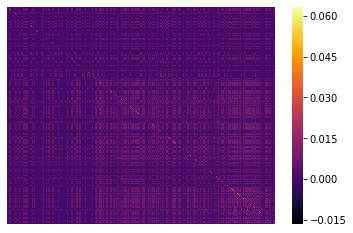

In [5]:
df_covfull = pd.DataFrame(covfull)
sns.heatmap(df_covfull, annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno',
            vmax=maxcov, vmin=mincov,robust=True)

In [6]:
eigenval, eigenvec = sp.linalg.eigh(covfull)

In [7]:
def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q

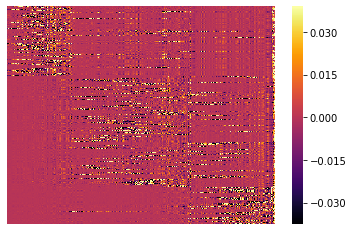

In [8]:
ortM = np.array(gram_schmidt_columns(np.real(eigenvec)))
sns.heatmap(pd.DataFrame(ortM), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=True)

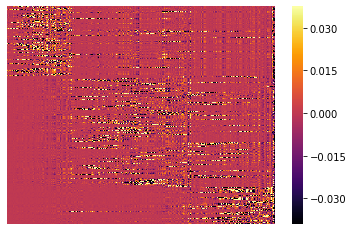

In [9]:
df_eig = pd.DataFrame(eigenvec)
sns.heatmap(df_eig, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno', 
            robust=True)

In [10]:
original_dim = 740
intermediate_dim1 = 300
intermediate_dim2 = 100
latent_dim = 1

inputs = tf.keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim1, activation='relu')(inputs)
h2 = layers.Dense(intermediate_dim2, activation='relu')(h)
z_mean = layers.Dense(latent_dim)(h2)
z_log_sigma = layers.Dense(latent_dim)(h2)

In [11]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [12]:
z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [13]:
# Create encoder
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim1, activation='relu')(latent_inputs)
x2 = layers.Dense(intermediate_dim2, activation='relu')(x)
outputs = layers.Dense(original_dim, activation='sigmoid')(x2)
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')

In [14]:
# reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [15]:
split = 0.9
ntrain = int(split * len(eigenvec))
indx = [ntrain]
# eigscaler = StandardScaler()
# eigscaler = MinMaxScaler(feature_range=(-1,1))
# eigscaler.fit(eigenvec)
# eigenvec = eigscaler.transform(eigenvec)
randomize = np.random.permutation(len(eigenvec))
eigenvec = eigenvec[randomize]
evec_train, evec_test = np.split(eigenvec, indx)
evec_train, evec_test = np.split(eigenvec, indx)

In [ ]:
vae_train = vae.fit(evec_train, evec_train,
        epochs=1000,
        batch_size=8,
        shuffle=True,
        validation_data=(evec_test, evec_test))

Epoch 1/1000
84/84 [==============================] - 0s 5ms/step - loss: 53.9844 - val_loss: 3.6116
Epoch 2/1000
84/84 [==============================] - 0s 3ms/step - loss: 2.6702 - val_loss: 2.0207
Epoch 3/1000
84/84 [==============================] - 0s 3ms/step - loss: 1.7283 - val_loss: 1.4182
Epoch 4/1000
84/84 [==============================] - 0s 3ms/step - loss: 1.2588 - val_loss: 1.1295
Epoch 5/1000
84/84 [==============================] - 0s 3ms/step - loss: 1.0697 - val_loss: 1.0295
Epoch 6/1000
84/84 [==============================] - 0s 3ms/step - loss: 1.0153 - val_loss: 1.0051
Epoch 7/1000
84/84 [==============================] - 0s 3ms/step - loss: 1.0027 - val_loss: 1.0016
Epoch 8/1000
84/84 [==============================] - 0s 3ms/step - loss: 1.0009 - val_loss: 1.0014
Epoch 9/1000
84/84 [==============================] - 0s 3ms/step - loss: 1.0007 - val_loss: 1.0009
Epoch 10/1000
84/84 [==============================] - 0s 3ms/step - loss: 1.0005 - val_loss: 1.000

84/84 [==============================] - 0s 3ms/step - loss: 0.9999 - val_loss: 1.0014
Epoch 83/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.9998 - val_loss: 1.0011
Epoch 84/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.9999 - val_loss: 1.0010
Epoch 85/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.9999 - val_loss: 1.0012
Epoch 86/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.9999 - val_loss: 1.0012
Epoch 87/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.9998 - val_loss: 1.0013
Epoch 88/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.9998 - val_loss: 1.0010
Epoch 89/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.9998 - val_loss: 1.0012
Epoch 90/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.9999 - val_loss: 1.0011
Epoch 91/1000
84/84 [==============================] - 0s 3ms/step - loss: 0.9998 - val_loss: 1.0013
Epoc

In [ ]:
plt.plot(vae_train.history['loss'], color='r')
plt.plot(vae_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
evec_test_encoded = encoder.predict(evec_test)
# plt.figure(figsize=(6, 6))
plt.scatter(evec_test_encoded[0], evec_test_encoded[1], c=evec_test_encoded[2])
plt.colorbar()
# plt.show()
np.shape(evec_test_encoded)

In [ ]:
encoded_vals = encoder.predict(evec_test)
maxlatent = np.max(encoded_vals)
minlatent = np.min(encoded_vals)
print(np.min(encoded_vals), np.max(encoded_vals))

In [ ]:
r = np.random.uniform(minlatent, maxlatent, size=740)
# r = np.linspace(minlatent, maxlatent, 740)
# rs = eigscaler.transform(r)
pred_random = decoder.predict(r)
# pred_random = pred_random[:,:1048]
# pred_random = eigscaler.inverse_transform(pred_random)
# pred_random *= 1e-10 
# eigscaler = MinMaxScaler(feature_range=(-1, 1))
# df_pred = pd.DataFrame(eigscaler.inverse_transform(pred_random))
df_pred = pd.DataFrame(pred_random)
sns.heatmap(df_pred, annot=False, fmt='g', xticklabels=False, yticklabels=False, cmap = 'inferno', 
            robust=True)